In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Structure Input
E: float = 30e6
I: float = 500

In [4]:
nodes = np.array([[i, 0] for i in range(0, 504, 24)])
bars = np.array([[i, i+1] for i in range(20)])

In [5]:
class Beam:
    def __init__(self, young, inertia, node: np.ndarray, bar: np.ndarray):
        self.young = young
        self.inertia = inertia
        self.node = node.astype(float)
        self.bar = bar.astype(int)

        self.dof = 2
        self.point_load = np.zeros_like(node)
        self.distributed_load = np.zeros([len(bar), 2])
        self.support = np.ones_like(node).astype(int)
        self.section = np.ones(len(bar))

        self.force = np.zeros([len(bar), 2 * self.dof])
        self.displacement = np.zeros([len(bar), 2 * self.dof])

    def analysis(self):
        nn = len(self.node)
        ne = len(self.bar)
        n_dof = self.dof * nn

        # Length
        d = self.node[self.bar[:, 1], :] - self.node[self.bar[:, 0], :]
        length = np.sqrt((d ** 2).sum(axis = 1))

        # Structural Stiffness
        matrix = np.zeros([2 * self.dof, 2 * self.dof])
        k = np.zeros([ne, 2 * self.dof, 2 * self.dof])
        ss = np.zeros([n_dof, n_dof])
        for i in range(ne):
            # DOF
            aux = self.dof * self.bar[i, :]
            index = np.r_[aux[0]: aux[0] + self.dof, aux[1]: aux[1] + self.dof]

            # Element stiffness matrix
            l: float = length[i]
            matrix[0] = [12, 6 * l, -12, 6 * l]
            matrix[1] = [6 * l, 4 * l ** 2, -6 * l, 2 * l ** 2]
            matrix[2] = [-12, -6 * l, 12, -6 * l]
            matrix[3] = [6 * l, 2 * l ** 2, -6 * l, 4 * l ** 2]
            k[i] = self.young * self.inertia * matrix / l ** 3

            # Global Stiffness Matrix
            ss[np.ix_(index, index)] += k[i]
            
        #Distributed load
        eq_load_ele =  np.zeros([len(self.bar), 2 * self.dof])
        for i in range(ne):
            l: float = length[i]
            pi: float = self.distributed_load[i, 0]
            pf: float = self.distributed_load[i, 1]
            eq_load_ele[i, 0] = l * (21 * pi + 9 * pf) / 60
            eq_load_ele[i, 1] = l * (l * (3 * pi + 2 * pf)) / 60
            eq_load_ele[i, 2] = l * (9 * pi + 21 * pf) / 60
            eq_load_ele[i, 3] = l * (l * (-2 * pi - 3 * pf)) / 60
        
        # Point load
        for i in range(ne):
            self.point_load[self.bar[i, 0], 0] += eq_load_ele[i, 0]
            self.point_load[self.bar[i, 0], 1] += eq_load_ele[i, 1]
            self.point_load[self.bar[i, 1], 0] += eq_load_ele[i, 2]
            self.point_load[self.bar[i, 1], 1] += eq_load_ele[i, 3]

        # Solution
        free_dof = self.support.flatten().nonzero()[0]
        kff = ss[np.ix_(free_dof, free_dof)]
        p = self.point_load.flatten()
        pf = p[free_dof]
        uf = np.linalg.solve(kff, pf)
        u = self.support.astype (float).flatten()
        u[free_dof] = uf
        u = u.reshape(nn, self.dof)
        u_ele = np.concatenate((u[self.bar[:, 0]], u[self.bar[:, 1]]), axis=1)
        for i in range(ne):
            self.force[i] = np.dot(k[i], u_ele[i]) - eq_load_ele[i]
            self.displacement[i] = u_ele[i]

    def plot(self, scale=None):
        ne = len(self.bar)
        fig, axs = plt.subplots(3)

        # Deformed Shape
        for i in range(ne):
            xi, xf = self.node[self.bar[i, 0], 0], self.node [self.bar [i, 1], 0]
            yi, yf = self.node[self.bar[i, 0], 1], self.node [self.bar [i, 1], 1]
            axs[0].plot([xi, xf], [yi, yf], 'b', linewidth=1)
        for i in range(ne):
            dxi, dxf = self.node [self.bar[i, 0], 0], self.node [self.bar[i, 1], 0]
            dyi = self.node[self.bar[i, 0], 1] + self.displacement [i, 0] * scale
            dyf = self.node[self.bar[i, 1], 1] + self.displacement [i, 2] * scale
            axs[0].plot([dxi, dxf], [dyi, dyf], 'r', linewidth=2)
            axs[0].text(dxi, dyi, str (round (dyi / scale, 4)), rotation=90)

        # Bending Moment
        axs[1].invert_yaxis()
        for i in range(ne):
            mxi, mxf = self.node [self.bar [i, 0], 0], self.node [self.bar[i, 1], 0]
            myi, myf = self.node[self.bar [i, 0], 1], self.node [self.bar [i, 1], 1]
            axs[1].plot([mxi, mxf], [myi, myf], 'b', linewidth=1)
        for i in range(ne):
            mr_xi, mr_xf = self.node[self.bar[i, 0], 0], self.node [self.bar[i, 1], 0]
            mr_yi = self.force[i, 1]
            mr_yf = self.force[i, 3]
            axs[1].plot([mr_xi, mr_xi, mr_xf, mr_xf], [0, mr_yi, mr_yf, 0], 'r', linewidth=1)
            axs[1].fill([mr_xi, mr_xi, mr_xf, mr_xf], [0, mr_yi, mr_yf, 0], 'c', alpha=0.3)
            axs[1].text(mr_xi, mr_yi, str(round(mr_yi, 4)), rotation=90)

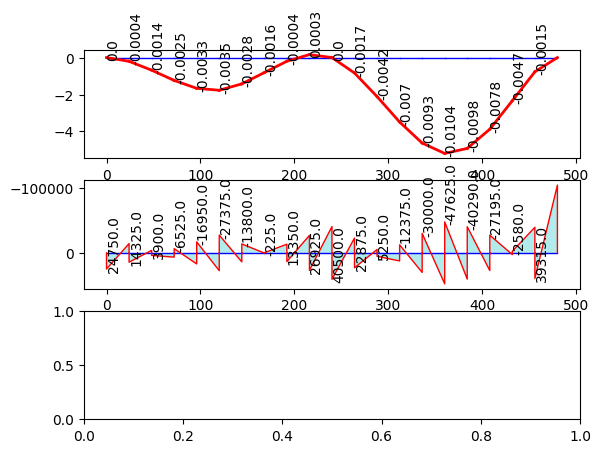

In [6]:
beam_1 = Beam(E, I, nodes, bars)

point_Load_1 = beam_1.point_load
point_Load_1[5, 0] = -1e3
point_Load_1[15, 0] = -1e3

distributed_load_1 = beam_1.distributed_load
distributed_load_1[15] = np.array([0, -10])
distributed_load_1[16] = np.array([-10, -20])
distributed_load_1[17] = np.array([-20, -30])
distributed_load_1[18] = np.array([-30, -40])
distributed_load_1[19] = np.array([-40, -50])

support_1 = beam_1.support
support_1[0, :] = 0
support_1[10, 0] = 0
support_1[20, :] = 0

beam_1.analysis()

beam_1.plot(500)